In [1]:
!pip install kagglehub librosa tensorflow scikit-learn matplotlib seaborn tqdm numpy pandas

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LSTM, TimeDistributed, BatchNormalization


print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# 2. Download the TESS Dataset using KaggleHub
import kagglehub

path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Dataset downloaded successfully!")
print("Path to dataset files:", path)


Dataset downloaded successfully!
Path to dataset files: C:\Users\DynastyX-koko\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1


In [4]:
# 3. Explore Dataset Structure
emotion_folders = sorted(os.listdir(path))
print("Emotions available:", emotion_folders)

Emotions available: ['TESS Toronto emotional speech set data']


In [5]:
# Collect all .wav files recursively (deep search)
wav_files = glob.glob(os.path.join(path, "**/*.wav"), recursive=True)
print(f"Total audio files found: {len(wav_files)}")

def extract_features(file_path, n_mfcc=40, max_len=174):
    """Extract MFCC features from an audio file."""
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc


Total audio files found: 5600


In [6]:
# EXPLORATORY DATA ANALYSIS (EDA)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display

# Create a DataFrame with file paths and emotions
file_paths = glob.glob(os.path.join(path, "**/*.wav"), recursive=True)

def get_emotion_from_path(file_path):
    folder = os.path.basename(os.path.dirname(file_path))
    emotion = folder.split('_')[-1].lower()
    return emotion

data = {'path': file_paths,
        'emotion': [get_emotion_from_path(fp) for fp in file_paths]}

df = pd.DataFrame(data)
print("DataFrame shape:", df.shape)
df.head()


DataFrame shape: (5600, 2)


,path,emotion
0,C:\Users\DynastyX-koko\.cache\kagglehub\datase...,angry
1,C:\Users\DynastyX-koko\.cache\kagglehub\datase...,angry
2,C:\Users\DynastyX-koko\.cache\kagglehub\datase...,angry
3,C:\Users\DynastyX-koko\.cache\kagglehub\datase...,angry
4,C:\Users\DynastyX-koko\.cache\kagglehub\datase...,angry


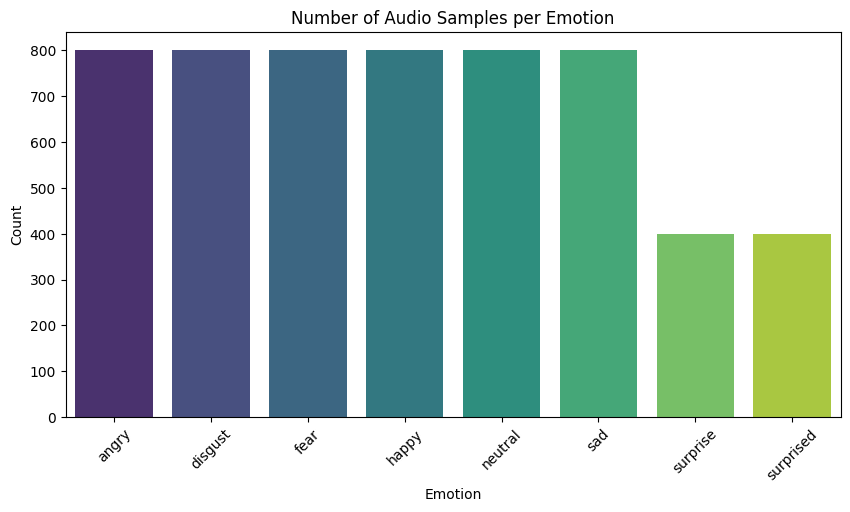

In [7]:
# Count of samples per emotion
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='viridis')
plt.title('Number of Audio Samples per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [8]:
# Helper functions for waveform and spectrogram plots
def plot_waveform(file_path):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 3))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.title(f"Mel Spectrogram - {os.path.basename(file_path)}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()



Emotion: ANGRY


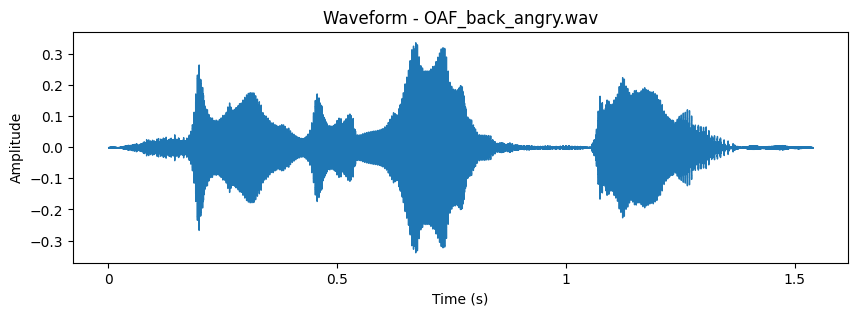

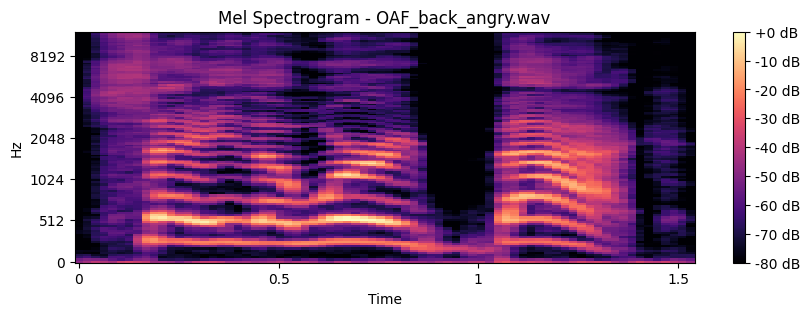


Emotion: DISGUST


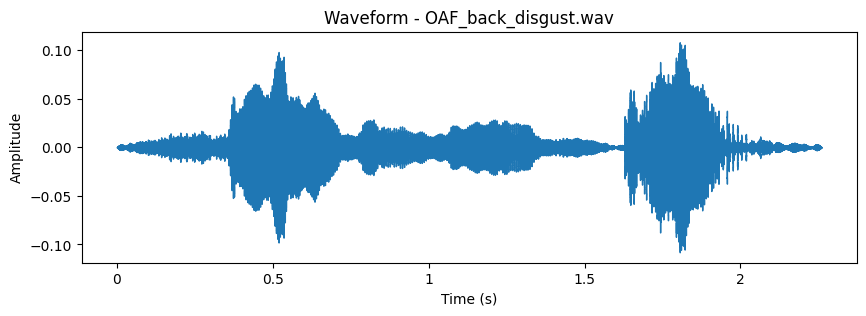

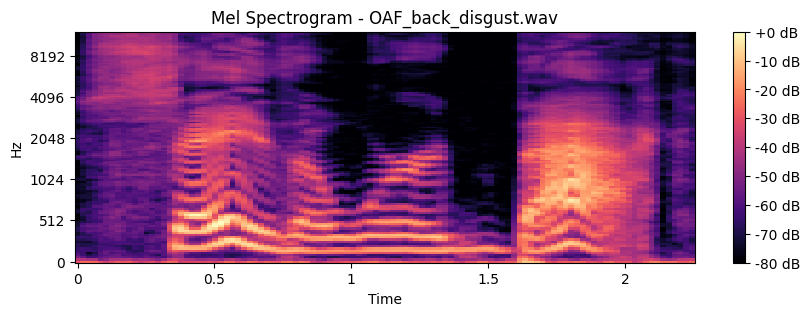


Emotion: FEAR


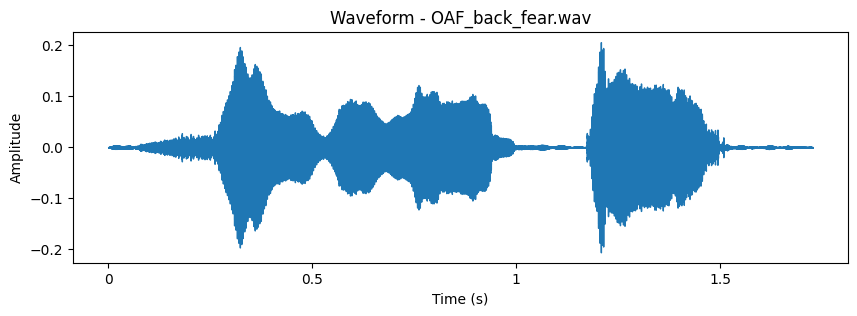

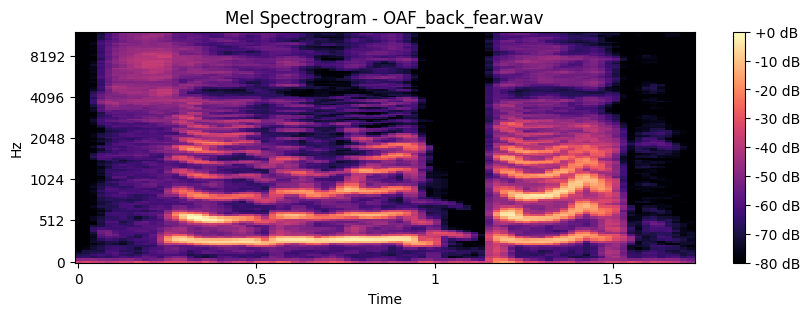


Emotion: HAPPY


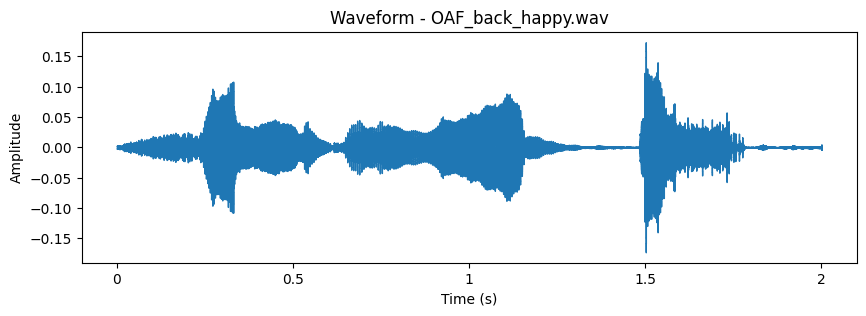

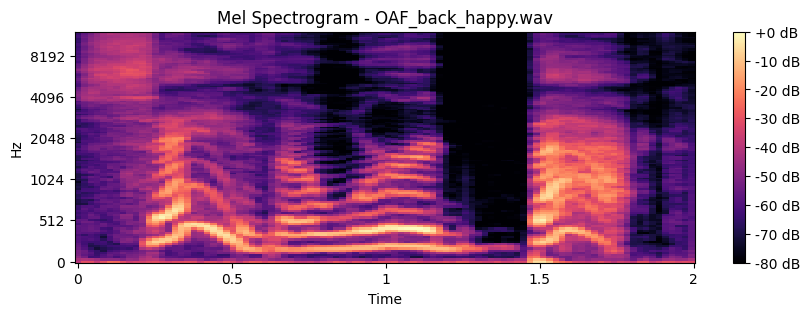


Emotion: NEUTRAL


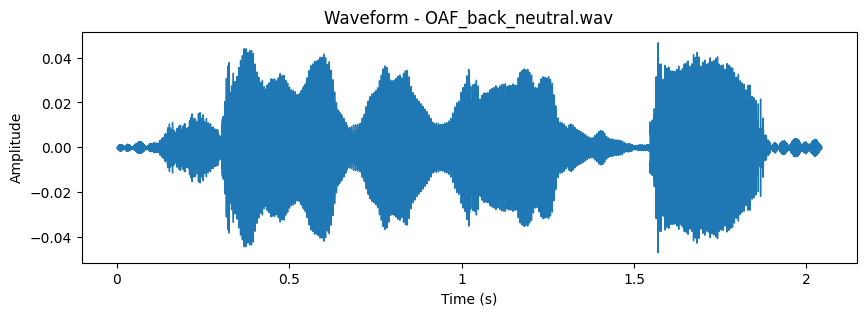

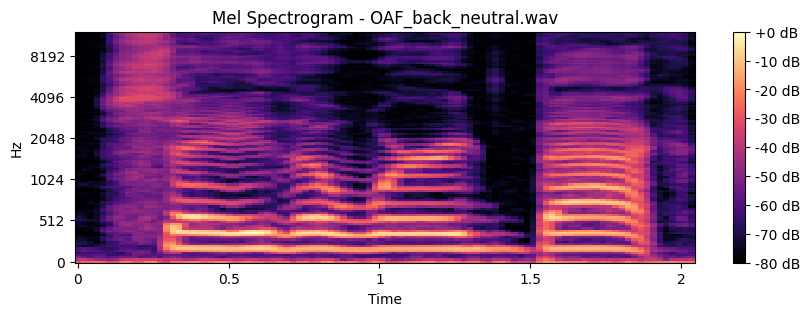


Emotion: SURPRISE


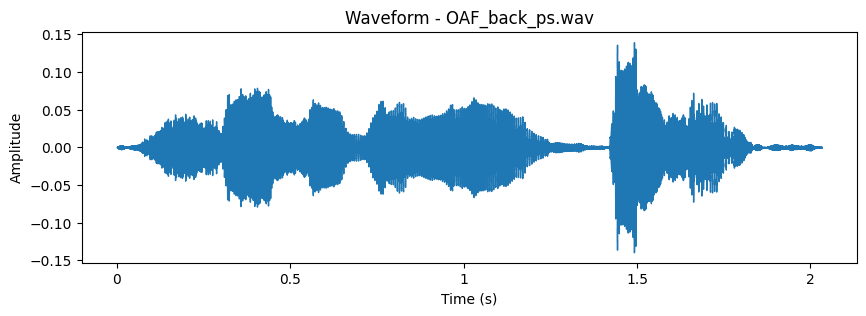

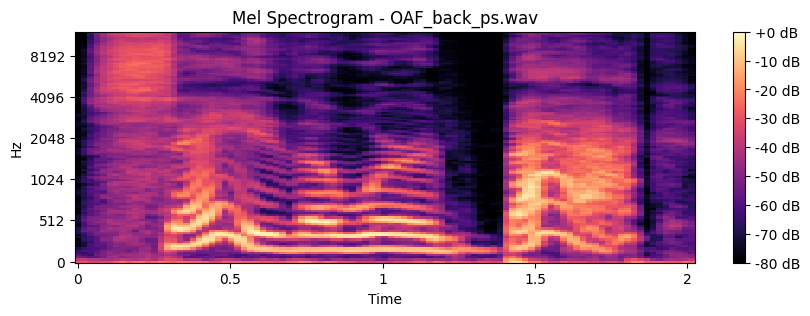


Emotion: SAD


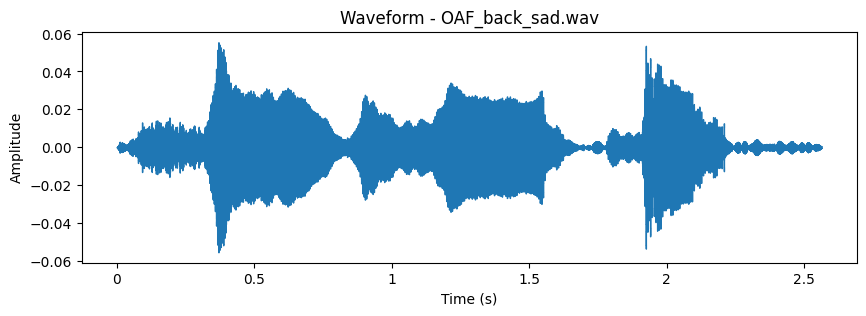

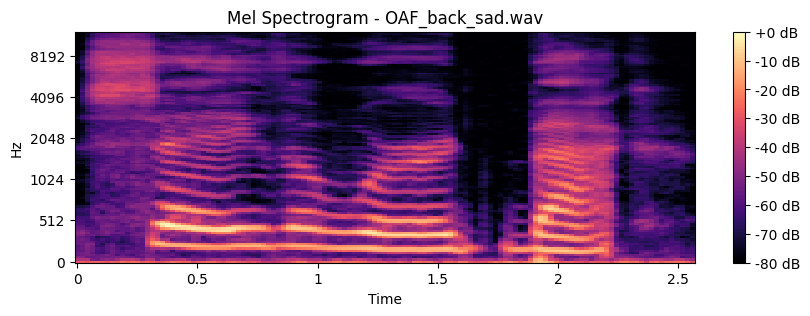


Emotion: SURPRISED


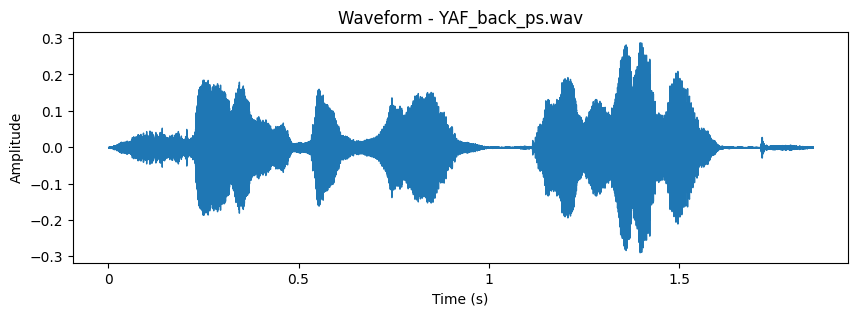

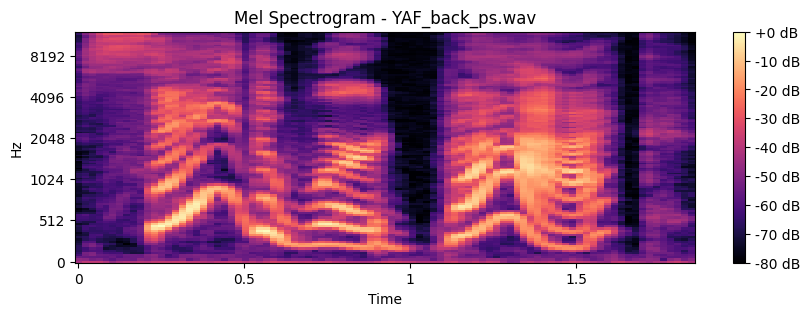

In [10]:
# Display examples for each emotion
sample_files = df.groupby('emotion').head(1)['path']

for file in sample_files:
    emotion = get_emotion_from_path(file)
    print(f"\nEmotion: {emotion.upper()}")
    plot_waveform(file)
    plot_spectrogram(file)


In [11]:
X, y = [], []

for file in tqdm(wav_files, desc="Extracting features"):
    emotion = get_emotion_from_path(file)
    features = extract_features(file)
    X.append(features)
    y.append(emotion)

X = np.array(X)
y = np.array(y)

print("Features extracted successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample emotions:", np.unique(y))

Extracting features: 100%|██████████| 5600/5600 [00:50<00:00, 110.91it/s]


Features extracted successfully!
X shape: (5600, 40, 174)
y shape: (5600,)
Sample emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise' 'surprised']


In [12]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)



Training data shape: (4480, 40, 174, 1)
Testing data shape: (1120, 40, 174, 1)


In [13]:
model = Sequential([
    # CNN feature extractor
    Conv2D(64, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    BatchNormalization(),

    # Flatten and reshape for LSTM
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(y_onehot.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 42, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 5376)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     2,818,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,911,368 (11.11 MB)

 Trainable params: 2,910,984 (11.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)


Epoch 1/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 317ms/step - accuracy: 0.9049 - loss: 0.3239 - val_accuracy: 0.9786 - val_loss: 0.0666
Epoch 2/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 297ms/step - accuracy: 0.9904 - loss: 0.0374 - val_accuracy: 0.9946 - val_loss: 0.0176
Epoch 3/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9933 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 4/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 325ms/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 0.9982 - val_loss: 0.0031
Epoch 5/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 6.6176e-04
Epoch 6/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9982 - val_loss: 0.0085
Epoch 7/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 352ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 0.9982 - val_loss: 0.0086
Epoch 8/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.9958 - los

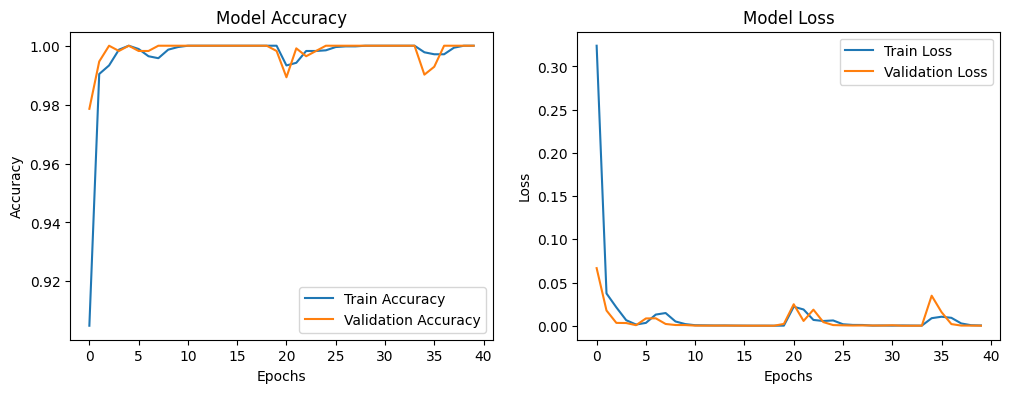

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")


Test Accuracy: 100.00%


In [17]:
import random
def predict_emotion(file_path):
    mfcc = extract_features(file_path)
    mfcc = np.expand_dims(mfcc, axis=0)
    mfcc = mfcc[..., np.newaxis]
    prediction = model.predict(mfcc)
    predicted_emotion = le.inverse_transform([np.argmax(prediction)])
    return predicted_emotion[0]

# Use recursive search to find .wav files in all nested folders
all_audio_files = glob.glob(os.path.join(path, "**/*.wav"), recursive=True)
print(f"Found {len(all_audio_files)} audio files for prediction testing.")

# Check that we actually found files
if len(all_audio_files) == 0:
    raise FileNotFoundError("No .wav files found. Check dataset path or KaggleHub download.")

# Randomly pick one to test
sample_audio = random.choice(all_audio_files)
print("Sample File:", sample_audio)

# Predict emotion
pred = predict_emotion(sample_audio)
print("Predicted Emotion:", pred)

Found 5600 audio files for prediction testing.
Sample File: C:\Users\DynastyX-koko\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1\TESS Toronto emotional speech set data\YAF_sad\YAF_gin_sad.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Predicted Emotion: sad


In [ ]:
model.save("models/emotion_recognition_model.h5")
import joblib
joblib.dump(le, "models/label_encoder.pkl")

print("Model and label encoder saved successfully!")


Model and label encoder saved successfully!
